# **PREPARATION**

## **Import Library**

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras import optimizers
from keras.layers import Input
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, GRU
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score


seed = 1234
np.random.seed(seed)
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## **Import Data**

In [74]:
df = pd.read_csv("Dataset/Dogecoin_7Year(25Dec2017-31Dec2024).csv")

## **Check Data**

### **Detailed Information**

In [75]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,12/31/2024,0.315964,0.313853,0.328516,0.309553,1.68B,0.67%
1,12/30/2024,0.313868,0.314281,0.322951,0.306930,1.90B,-0.13%
2,12/29/2024,0.314269,0.324238,0.329441,0.311975,1.30B,-3.07%
3,12/28/2024,0.324226,0.311800,0.326986,0.311457,1.03B,3.99%
4,12/27/2024,0.311800,0.312739,0.324650,0.309023,1.63B,-0.30%
...,...,...,...,...,...,...,...
2559,12/29/2017,0.009228,0.008244,0.009450,0.007577,637.88M,11.94%
2560,12/28/2017,0.008244,0.008861,0.008869,0.007221,543.30M,-6.96%
2561,12/27/2017,0.008861,0.009332,0.009600,0.008090,505.32M,-5.05%
2562,12/26/2017,0.009332,0.008648,0.009686,0.008000,608.89M,7.91%


In [76]:
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2564 entries, 0 to 2563
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2564 non-null   object 
 1   Price     2564 non-null   float64
 2   Open      2564 non-null   float64
 3   High      2564 non-null   float64
 4   Low       2564 non-null   float64
 5   Vol.      2564 non-null   object 
 6   Change %  2564 non-null   object 
dtypes: float64(4), object(3)
memory usage: 140.3+ KB


In [78]:
df.describe()

,Price,Open,High,Low
count,2564.000000,2564.000000,2564.000000,2564.000000
mean,0.078330,0.078214,0.082222,0.074272
std,0.097435,0.097338,0.103849,0.090642
min,0.001585,0.001580,0.001720,0.001291
25%,0.002901,0.002901,0.003005,0.002802
50%,0.061977,0.061927,0.063308,0.060544
75%,0.109773,0.109717,0.114145,0.105704
max,0.686880,0.686914,0.738255,0.605162


### **Missing Values**

#### in Boolean

In [79]:
any_missing = df.isnull().any()
any_missing

Date        False
Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

#### in Amount

In [80]:
missing_values_count = df.isnull().sum()
missing_values_count

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

### **Data Duplicate**

In [81]:
duplicates = df[df.duplicated(keep=False)]

if not duplicates.empty:
    print(f"There is {len(duplicates)} data duplicate:")
    print(duplicates)
else:
    print("No data duplicate.")

duplicates

No data duplicate.


,Date,Price,Open,High,Low,Vol.,Change %


### **Data Outlier**

In [82]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

outliers = (df['Price'] < (Q1 - 1.5 * IQR)) | (df['Price'] > (Q3 + 1.5 * IQR))

df_outliers = df[outliers]
print("Outliers:")
print(df_outliers)


Outliers:
            Date     Price      Open      High       Low    Vol. Change %
0     12/31/2024  0.315964  0.313853  0.328516  0.309553   1.68B    0.67%
1     12/30/2024  0.313868  0.314281  0.322951  0.306930   1.90B   -0.13%
2     12/29/2024  0.314269  0.324238  0.329441  0.311975   1.30B   -3.07%
3     12/28/2024  0.324226  0.311800  0.326986  0.311457   1.03B    3.99%
4     12/27/2024  0.311800  0.312739  0.324650  0.309023   1.63B   -0.30%
...          ...       ...       ...       ...       ...     ...      ...
1351  04/20/2021  0.317696  0.407451  0.422212  0.271758  33.27B  -22.01%
1352  04/19/2021  0.407335  0.322197  0.433969  0.309128  31.68B   26.49%
1353  04/18/2021  0.322037  0.282723  0.349748  0.239707  29.11B   14.23%
1354  04/17/2021  0.281909  0.365389  0.378924  0.232010  39.28B  -22.88%
1355  04/16/2021  0.365551  0.182628  0.449889  0.180132  83.39B   99.99%

[144 rows x 7 columns]


# **TRANSFORMATION**

## **Data Sorting by Date**


In [83]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

df = df.sort_values(by='Date')

df.reset_index(drop=True, inplace=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2017-12-25,0.008648,0.008356,0.011020,0.008124,713.90M,3.49%
1,2017-12-26,0.009332,0.008648,0.009686,0.008000,608.89M,7.91%
2,2017-12-27,0.008861,0.009332,0.009600,0.008090,505.32M,-5.05%
3,2017-12-28,0.008244,0.008861,0.008869,0.007221,543.30M,-6.96%
4,2017-12-29,0.009228,0.008244,0.009450,0.007577,637.88M,11.94%
...,...,...,...,...,...,...,...
2559,2024-12-27,0.311800,0.312739,0.324650,0.309023,1.63B,-0.30%
2560,2024-12-28,0.324226,0.311800,0.326986,0.311457,1.03B,3.99%
2561,2024-12-29,0.314269,0.324238,0.329441,0.311975,1.30B,-3.07%
2562,2024-12-30,0.313868,0.314281,0.322951,0.306930,1.90B,-0.13%


## **Converting Data Value to Numeric (Encoding)**

### **Volume Column**

In [84]:
def convert_volume(vol):
    if 'M' in vol:
        return float(vol.replace('M', '')) * 1e6
    elif 'B' in vol:
        return float(vol.replace('B', '')) * 1e9
    elif 'K' in vol:
        return float(vol.replace('K', '')) * 1e3
    return vol

In [85]:
df['Vol.'] = df['Vol.'].apply(convert_volume)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2017-12-25,0.008648,0.008356,0.011020,0.008124,7.139000e+08,3.49%
1,2017-12-26,0.009332,0.008648,0.009686,0.008000,6.088900e+08,7.91%
2,2017-12-27,0.008861,0.009332,0.009600,0.008090,5.053200e+08,-5.05%
3,2017-12-28,0.008244,0.008861,0.008869,0.007221,5.433000e+08,-6.96%
4,2017-12-29,0.009228,0.008244,0.009450,0.007577,6.378800e+08,11.94%
...,...,...,...,...,...,...,...
2559,2024-12-27,0.311800,0.312739,0.324650,0.309023,1.630000e+09,-0.30%
2560,2024-12-28,0.324226,0.311800,0.326986,0.311457,1.030000e+09,3.99%
2561,2024-12-29,0.314269,0.324238,0.329441,0.311975,1.300000e+09,-3.07%
2562,2024-12-30,0.313868,0.314281,0.322951,0.306930,1.900000e+09,-0.13%


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2564 entries, 0 to 2563
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2564 non-null   datetime64[ns]
 1   Price     2564 non-null   float64       
 2   Open      2564 non-null   float64       
 3   High      2564 non-null   float64       
 4   Low       2564 non-null   float64       
 5   Vol.      2564 non-null   float64       
 6   Change %  2564 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 140.3+ KB


### **Change Column**

In [87]:
df['Change %'] = df['Change %'].str.rstrip('%').str.replace(',', '').astype('float') # Replace commas before converting to float
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2017-12-25,0.008648,0.008356,0.011020,0.008124,7.139000e+08,3.49
1,2017-12-26,0.009332,0.008648,0.009686,0.008000,6.088900e+08,7.91
2,2017-12-27,0.008861,0.009332,0.009600,0.008090,5.053200e+08,-5.05
3,2017-12-28,0.008244,0.008861,0.008869,0.007221,5.433000e+08,-6.96
4,2017-12-29,0.009228,0.008244,0.009450,0.007577,6.378800e+08,11.94
...,...,...,...,...,...,...,...
2559,2024-12-27,0.311800,0.312739,0.324650,0.309023,1.630000e+09,-0.30
2560,2024-12-28,0.324226,0.311800,0.326986,0.311457,1.030000e+09,3.99
2561,2024-12-29,0.314269,0.324238,0.329441,0.311975,1.300000e+09,-3.07
2562,2024-12-30,0.313868,0.314281,0.322951,0.306930,1.900000e+09,-0.13


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2564 entries, 0 to 2563
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2564 non-null   datetime64[ns]
 1   Price     2564 non-null   float64       
 2   Open      2564 non-null   float64       
 3   High      2564 non-null   float64       
 4   Low       2564 non-null   float64       
 5   Vol.      2564 non-null   float64       
 6   Change %  2564 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 140.3 KB


## **Added Features Engineering**

### **Date Feature**

In [89]:
df['Day'] = df['Date'].dt.day
df['Week'] = df['Date'].apply(lambda d: (d.day - 1) // 7 + 1)
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df

,Date,Price,Open,High,Low,Vol.,Change %,Day,Week,Month,Year
0,2017-12-25,0.008648,0.008356,0.011020,0.008124,7.139000e+08,3.49,25,4,12,2017
1,2017-12-26,0.009332,0.008648,0.009686,0.008000,6.088900e+08,7.91,26,4,12,2017
2,2017-12-27,0.008861,0.009332,0.009600,0.008090,5.053200e+08,-5.05,27,4,12,2017
3,2017-12-28,0.008244,0.008861,0.008869,0.007221,5.433000e+08,-6.96,28,4,12,2017
4,2017-12-29,0.009228,0.008244,0.009450,0.007577,6.378800e+08,11.94,29,5,12,2017
...,...,...,...,...,...,...,...,...,...,...,...
2559,2024-12-27,0.311800,0.312739,0.324650,0.309023,1.630000e+09,-0.30,27,4,12,2024
2560,2024-12-28,0.324226,0.311800,0.326986,0.311457,1.030000e+09,3.99,28,4,12,2024
2561,2024-12-29,0.314269,0.324238,0.329441,0.311975,1.300000e+09,-3.07,29,5,12,2024
2562,2024-12-30,0.313868,0.314281,0.322951,0.306930,1.900000e+09,-0.13,30,5,12,2024


### **Price Lag Feature**

In [90]:
for lag in range(1, 8):
    df[f'Price_lag_{lag}'] = df['Price'].shift(lag)
df

,Date,Price,Open,High,Low,Vol.,Change %,Day,Week,Month,Year,Price_lag_1,Price_lag_2,Price_lag_3,Price_lag_4,Price_lag_5,Price_lag_6,Price_lag_7
0,2017-12-25,0.008648,0.008356,0.011020,0.008124,7.139000e+08,3.49,25,4,12,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-12-26,0.009332,0.008648,0.009686,0.008000,6.088900e+08,7.91,26,4,12,2017,0.008648,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-12-27,0.008861,0.009332,0.009600,0.008090,5.053200e+08,-5.05,27,4,12,2017,0.009332,0.008648,NaN,NaN,NaN,NaN,NaN
3,2017-12-28,0.008244,0.008861,0.008869,0.007221,5.433000e+08,-6.96,28,4,12,2017,0.008861,0.009332,0.008648,NaN,NaN,NaN,NaN
4,2017-12-29,0.009228,0.008244,0.009450,0.007577,6.378800e+08,11.94,29,5,12,2017,0.008244,0.008861,0.009332,0.008648,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2559,2024-12-27,0.311800,0.312739,0.324650,0.309023,1.630000e+09,-0.30,27,4,12,2024,0.312750,0.334245,0.337012,0.324847,0.312698,0.320086,0.317795
2560,2024-12-28,0.324226,0.311800,0.326986,0.311457,1.030000e+09,3.99,28,4,12,2024,0.311800,0.312750,0.334245,0.337012,0.324847,0.312698,0.320086
2561,2024-12-29,0.314269,0.324238,0.329441,0.311975,1.300000e+09,-3.07,29,5,12,2024,0.324226,0.311800,0.312750,0.334245,0.337012,0.324847,0.312698
2562,2024-12-30,0.313868,0.314281,0.322951,0.306930,1.900000e+09,-0.13,30,5,12,2024,0.314269,0.324226,0.311800,0.312750,0.334245,0.337012,0.324847


In [91]:
df.dropna(inplace=True)
df

,Date,Price,Open,High,Low,Vol.,Change %,Day,Week,Month,Year,Price_lag_1,Price_lag_2,Price_lag_3,Price_lag_4,Price_lag_5,Price_lag_6,Price_lag_7
7,2018-01-01,0.008678,0.008927,0.008990,0.007960,5.752200e+08,-2.79,1,1,1,2018,0.008927,0.007672,0.009228,0.008244,0.008861,0.009332,0.008648
8,2018-01-02,0.009000,0.008678,0.009878,0.008316,7.211500e+08,3.71,2,1,1,2018,0.008678,0.008927,0.007672,0.009228,0.008244,0.008861,0.009332
9,2018-01-03,0.009205,0.009000,0.009345,0.008340,7.243400e+08,2.28,3,1,1,2018,0.009000,0.008678,0.008927,0.007672,0.009228,0.008244,0.008861
10,2018-01-04,0.009613,0.009205,0.010300,0.008559,6.344800e+08,4.43,4,1,1,2018,0.009205,0.009000,0.008678,0.008927,0.007672,0.009228,0.008244
11,2018-01-05,0.012550,0.009613,0.013950,0.009434,6.722600e+08,30.55,5,1,1,2018,0.009613,0.009205,0.009000,0.008678,0.008927,0.007672,0.009228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2559,2024-12-27,0.311800,0.312739,0.324650,0.309023,1.630000e+09,-0.30,27,4,12,2024,0.312750,0.334245,0.337012,0.324847,0.312698,0.320086,0.317795
2560,2024-12-28,0.324226,0.311800,0.326986,0.311457,1.030000e+09,3.99,28,4,12,2024,0.311800,0.312750,0.334245,0.337012,0.324847,0.312698,0.320086
2561,2024-12-29,0.314269,0.324238,0.329441,0.311975,1.300000e+09,-3.07,29,5,12,2024,0.324226,0.311800,0.312750,0.334245,0.337012,0.324847,0.312698
2562,2024-12-30,0.313868,0.314281,0.322951,0.306930,1.900000e+09,-0.13,30,5,12,2024,0.314269,0.324226,0.311800,0.312750,0.334245,0.337012,0.324847


#### **Information**

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2557 entries, 7 to 2563
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2557 non-null   datetime64[ns]
 1   Price        2557 non-null   float64       
 2   Open         2557 non-null   float64       
 3   High         2557 non-null   float64       
 4   Low          2557 non-null   float64       
 5   Vol.         2557 non-null   float64       
 6   Change %     2557 non-null   float64       
 7   Day          2557 non-null   int32         
 8   Week         2557 non-null   int64         
 9   Month        2557 non-null   int32         
 10  Year         2557 non-null   int32         
 11  Price_lag_1  2557 non-null   float64       
 12  Price_lag_2  2557 non-null   float64       
 13  Price_lag_3  2557 non-null   float64       
 14  Price_lag_4  2557 non-null   float64       
 15  Price_lag_5  2557 non-null   float64       
 16  Price_lag_6

In [93]:
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Day',
       'Week', 'Month', 'Year', 'Price_lag_1', 'Price_lag_2', 'Price_lag_3',
       'Price_lag_4', 'Price_lag_5', 'Price_lag_6', 'Price_lag_7'],
      dtype='object')

## **Data Normalization**

In [94]:
features = ['Open', 'High', 'Low', 'Vol.',
            'Price_lag_1', 'Price_lag_2', 'Price_lag_3', 'Price_lag_4', 'Price_lag_5', 'Price_lag_6', 'Price_lag_7']
target = 'Price'

In [95]:
df_norma = df.copy()

scaler_features = MinMaxScaler()
df_norma[features] = scaler_features.fit_transform(df[features])

scaler_target = MinMaxScaler()
df_norma[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

### **Data Normalization Result**

In [96]:
norma_result = df_norma[features + [target]]
norma_result

,Open,High,Low,Vol.,Price_lag_1,Price_lag_2,Price_lag_3,Price_lag_4,Price_lag_5,Price_lag_6,Price_lag_7,Price
7,0.010720,0.009871,0.011044,0.003217,0.010714,0.008882,0.011153,0.009717,0.010617,0.011305,0.010307,0.010350
8,0.010357,0.011076,0.011633,0.004212,0.010350,0.010714,0.008882,0.011153,0.009717,0.010617,0.011305,0.010820
9,0.010827,0.010353,0.011673,0.004233,0.010820,0.010350,0.010714,0.008882,0.011153,0.009717,0.010617,0.011119
10,0.011126,0.011649,0.012036,0.003621,0.011119,0.010820,0.010350,0.010714,0.008882,0.011153,0.009717,0.011715
11,0.011721,0.016605,0.013485,0.003878,0.011715,0.011119,0.010820,0.010350,0.010714,0.008882,0.011153,0.016000
...,...,...,...,...,...,...,...,...,...,...,...,...
2559,0.454025,0.438445,0.509599,0.010407,0.454060,0.485426,0.489464,0.471712,0.453984,0.464765,0.461422,0.452674
2560,0.452655,0.441616,0.513630,0.006317,0.452674,0.454060,0.485426,0.489464,0.471712,0.453984,0.464765,0.470806
2561,0.470804,0.444950,0.514487,0.008158,0.470806,0.452674,0.454060,0.485426,0.489464,0.471712,0.453984,0.456276
2562,0.456275,0.436138,0.506133,0.012248,0.456276,0.470806,0.452674,0.454060,0.485426,0.489464,0.471712,0.455691


## **Data Splitting**

In [97]:
train_size = int(len(df_norma) * 0.7)
val_size = int(len(df_norma) * 0.1)
test_size = len(df_norma) - train_size - val_size

train_df = df_norma.iloc[:train_size]
val_df = df_norma.iloc[train_size:train_size + val_size]
test_df = df_norma.iloc[train_size + val_size:]

X_train = train_df[features].values
y_train = train_df[target].values
X_val = val_df[features].values
y_val = val_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values

### **Splitting Result**

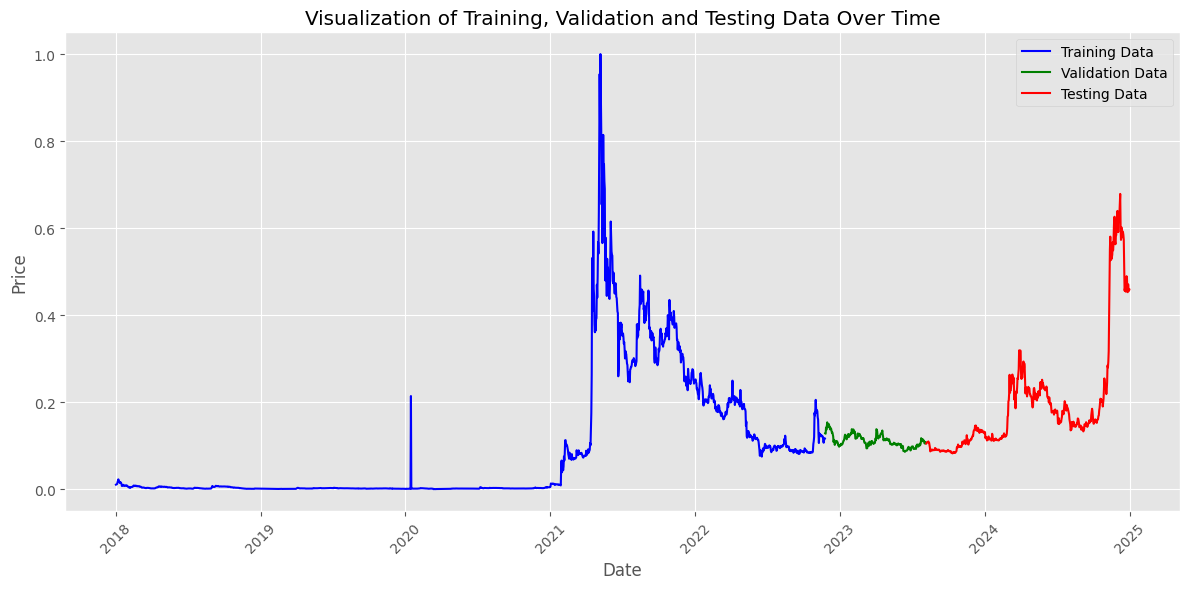

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Price'], label='Training Data', color='blue')
plt.plot(val_df['Date'], val_df['Price'], label='Validation Data', color='green')
plt.plot(test_df['Date'], test_df['Price'], label='Testing Data', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Visualization of Training, Validation and Testing Data Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Training Data**

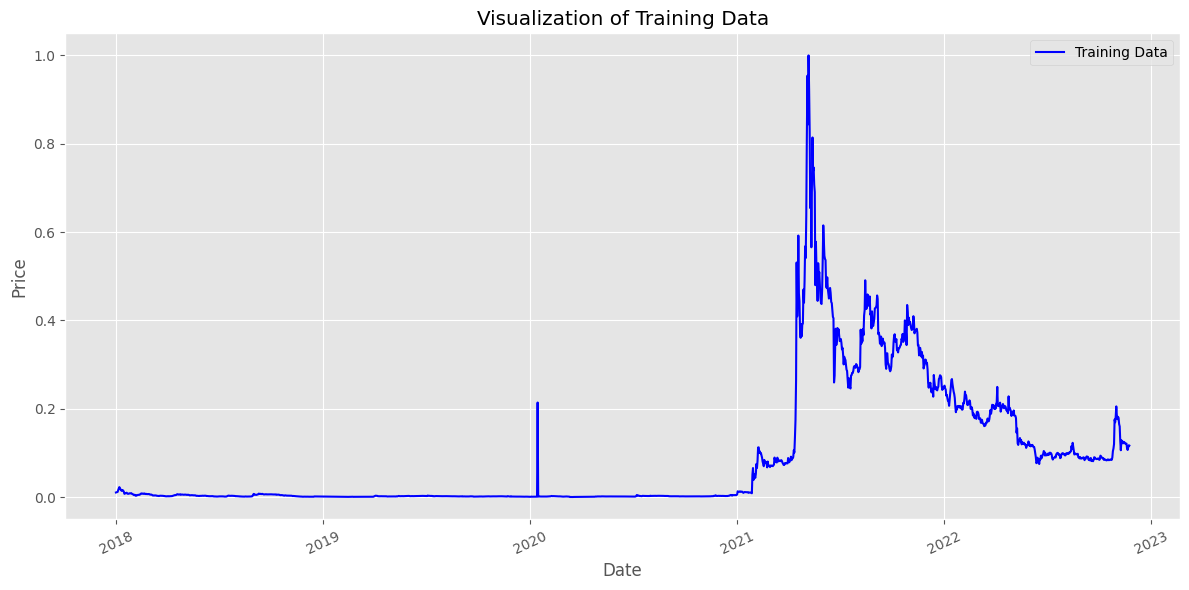

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Price'], label='Training Data', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Visualization of Training Data')
plt.legend()
plt.grid(True)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

In [100]:
train_df

,Date,Price,Open,High,Low,Vol.,Change %,Day,Week,Month,Year,Price_lag_1,Price_lag_2,Price_lag_3,Price_lag_4,Price_lag_5,Price_lag_6,Price_lag_7
7,2018-01-01,0.010350,0.010720,0.009871,0.011044,0.003217,-2.79,1,1,1,2018,0.010714,0.008882,0.011153,0.009717,0.010617,0.011305,0.010307
8,2018-01-02,0.010820,0.010357,0.011076,0.011633,0.004212,3.71,2,1,1,2018,0.010350,0.010714,0.008882,0.011153,0.009717,0.010617,0.011305
9,2018-01-03,0.011119,0.010827,0.010353,0.011673,0.004233,2.28,3,1,1,2018,0.010820,0.010350,0.010714,0.008882,0.011153,0.009717,0.010617
10,2018-01-04,0.011715,0.011126,0.011649,0.012036,0.003621,4.43,4,1,1,2018,0.011119,0.010820,0.010350,0.010714,0.008882,0.011153,0.009717
11,2018-01-05,0.016000,0.011721,0.016605,0.013485,0.003878,30.55,5,1,1,2018,0.011715,0.011119,0.010820,0.010350,0.010714,0.008882,0.011153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791,2022-11-20,0.110141,0.121023,0.114152,0.124681,0.009862,-8.83,20,3,11,2022,0.121034,0.120678,0.121410,0.121551,0.124684,0.123004,0.121711
1792,2022-11-21,0.106642,0.110168,0.102560,0.116285,0.015792,-3.11,21,3,11,2022,0.110141,0.121034,0.120678,0.121410,0.121551,0.124684,0.123004
1793,2022-11-22,0.112517,0.106646,0.105616,0.119322,0.012316,5.39,22,4,11,2022,0.106642,0.110141,0.121034,0.120678,0.121410,0.121551,0.124684
1794,2022-11-23,0.117312,0.112570,0.110985,0.126746,0.010680,4.18,23,4,11,2022,0.112517,0.106642,0.110141,0.121034,0.120678,0.121410,0.121551


### **Validation Data**

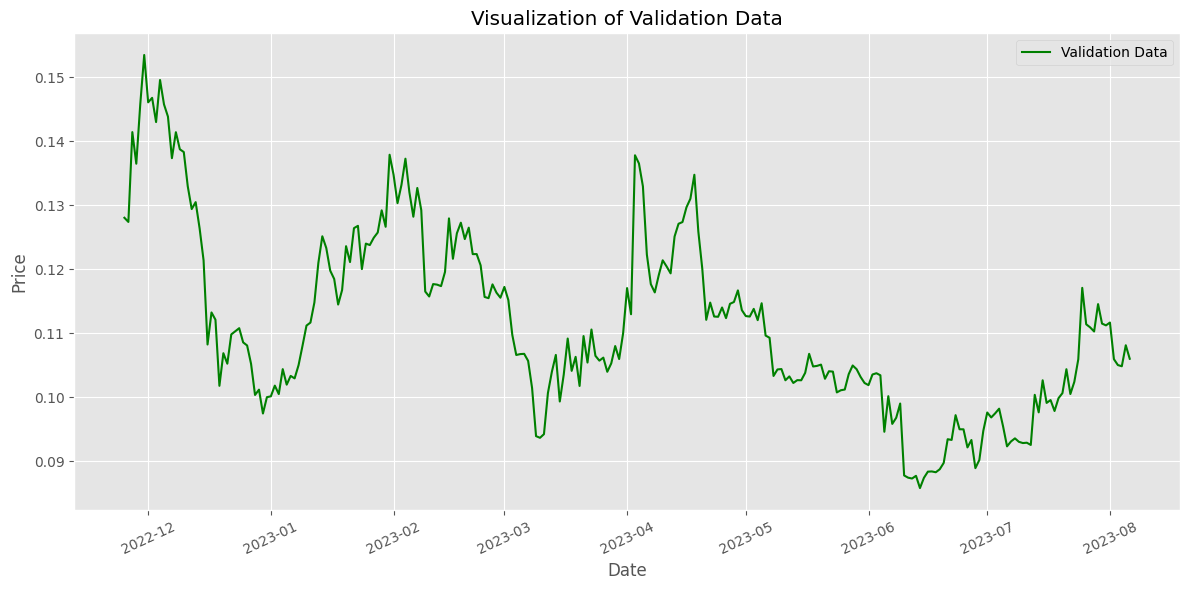

In [101]:
plt.figure(figsize=(12, 6))
plt.plot(val_df['Date'], val_df['Price'], label='Validation Data', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Visualization of Validation Data')
plt.legend()
plt.grid(True)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


In [102]:
val_df

,Date,Price,Open,High,Low,Vol.,Change %,Day,Week,Month,Year,Price_lag_1,Price_lag_2,Price_lag_3,Price_lag_4,Price_lag_5,Price_lag_6,Price_lag_7
1796,2022-11-25,0.128069,0.116555,0.121751,0.131627,0.021518,9.69,25,4,11,2022,0.116554,0.117312,0.112517,0.106642,0.110141,0.121034,0.120678
1797,2022-11-26,0.127418,0.128079,0.127003,0.142858,0.017156,-0.50,26,4,11,2022,0.128069,0.116554,0.117312,0.112517,0.106642,0.110141,0.121034
1798,2022-11-27,0.141449,0.127421,0.143965,0.144930,0.037197,10.82,27,4,11,2022,0.127418,0.128069,0.116554,0.117312,0.112517,0.106642,0.110141
1799,2022-11-28,0.136512,0.141474,0.132669,0.148201,0.028676,-3.43,28,4,11,2022,0.141449,0.127418,0.128069,0.116554,0.117312,0.112517,0.106642
1800,2022-11-29,0.145775,0.136516,0.140185,0.153048,0.025540,6.67,29,5,11,2022,0.136512,0.141449,0.127418,0.128069,0.116554,0.117312,0.112517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,2023-08-02,0.105982,0.111696,0.103942,0.120170,0.008158,-5.01,2,1,8,2023,0.111699,0.111260,0.111537,0.114584,0.110306,0.110946,0.111431
2047,2023-08-03,0.105063,0.105988,0.099479,0.118433,0.007749,-0.85,3,1,8,2023,0.105982,0.111699,0.111260,0.111537,0.114584,0.110306,0.110946
2048,2023-08-04,0.104872,0.105066,0.099333,0.118308,0.006999,-0.18,4,1,8,2023,0.105063,0.105982,0.111699,0.111260,0.111537,0.114584,0.110306
2049,2023-08-05,0.108155,0.104873,0.102052,0.118613,0.010475,3.06,5,1,8,2023,0.104872,0.105063,0.105982,0.111699,0.111260,0.111537,0.114584


### **Testing Data**

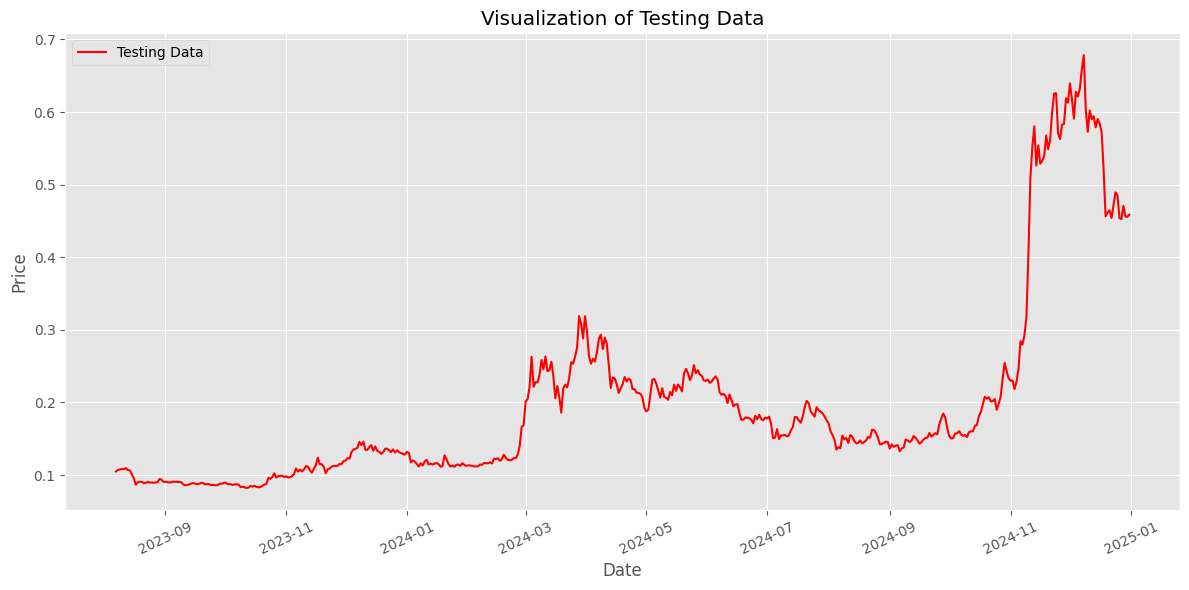

In [103]:
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], test_df['Price'], label='Testing Data', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Visualization of Testing Data')
plt.legend()
plt.grid(True)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


In [104]:
test_df

,Date,Price,Open,High,Low,Vol.,Change %,Day,Week,Month,Year,Price_lag_1,Price_lag_2,Price_lag_3,Price_lag_4,Price_lag_5,Price_lag_6,Price_lag_7
2051,2023-08-07,0.104994,0.106043,0.100388,0.116965,0.007408,-0.97,7,1,8,2023,0.106042,0.108155,0.104872,0.105063,0.105982,0.111699,0.111260
2052,2023-08-08,0.107090,0.104993,0.100131,0.119088,0.006726,1.95,8,2,8,2023,0.104994,0.106042,0.108155,0.104872,0.105063,0.105982,0.111699
2053,2023-08-09,0.107710,0.107085,0.101066,0.120802,0.006181,0.57,9,2,8,2023,0.107090,0.104994,0.106042,0.108155,0.104872,0.105063,0.105982
2054,2023-08-10,0.108396,0.107711,0.102075,0.122303,0.006931,0.62,10,2,8,2023,0.107710,0.107090,0.104994,0.106042,0.108155,0.104872,0.105063
2055,2023-08-11,0.108174,0.108391,0.100981,0.122216,0.004423,-0.20,11,2,8,2023,0.108396,0.107710,0.107090,0.104994,0.106042,0.108155,0.104872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2559,2024-12-27,0.452674,0.454025,0.438445,0.509599,0.010407,-0.30,27,4,12,2024,0.454060,0.485426,0.489464,0.471712,0.453984,0.464765,0.461422
2560,2024-12-28,0.470806,0.452655,0.441616,0.513630,0.006317,3.99,28,4,12,2024,0.452674,0.454060,0.485426,0.489464,0.471712,0.453984,0.464765
2561,2024-12-29,0.456276,0.470804,0.444950,0.514487,0.008158,-3.07,29,5,12,2024,0.470806,0.452674,0.454060,0.485426,0.489464,0.471712,0.453984
2562,2024-12-30,0.455691,0.456275,0.436138,0.506133,0.012248,-0.13,30,5,12,2024,0.456276,0.470806,0.452674,0.454060,0.485426,0.489464,0.471712


## **Converting Data to Format 3D**

In [105]:
timesteps = 30

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i + timesteps])
        ys.append(y[i + timesteps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, timesteps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, timesteps)

print("The results convert the data into 3D format: ")
print(f"Shape X_train_seq: {X_train_seq.shape}, y_train_seq: {y_train_seq.shape}")
print(f"Shape X_val_seq: {X_val_seq.shape}, y_val_seq: {y_val_seq.shape}")
print(f"Shape X_test_seq: {X_test_seq.shape}, y_test_seq: {y_test_seq.shape}")

The results convert the data into 3D format: 
Shape X_train_seq: (1759, 30, 11), y_train_seq: (1759,)
Shape X_val_seq: (225, 30, 11), y_val_seq: (225,)
Shape X_test_seq: (483, 30, 11), y_test_seq: (483,)


# **MODELING**

## **Gated Recurrent Unit (GRU)**

In [106]:
model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    GRU(128, activation='tanh', return_sequences=True),
    Dropout(0.4),
    GRU(128, activation='tanh'),
    Dropout(0.4),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs=200,
    batch_size=128,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping],
    verbose=1
)

model.summary()

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - loss: 0.0071 - val_loss: 1.9461e-04
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.0022 - val_loss: 6.0881e-05
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0017 - val_loss: 3.4718e-05
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0016 - val_loss: 5.8575e-05
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0014 - val_loss: 3.0838e-04
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0012 - val_loss: 1.7640e-04
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0014 - val_loss: 1.2386e-04
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.0017 - val_loss: 2.5920e-05
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 7.7988e-04 - val_loss: 2.6532e-05
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 9.8981e-04 - val_loss: 2.6024e-05
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0011 - val_loss: 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 30, 128)        │        54,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,037 (1.75 MB)

 Trainable params: 153,345 (599.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,692 (1.17 MB)

# **INTERPRETATION/EVALUATION**

## **Plot Training Loss & Validation Loss**

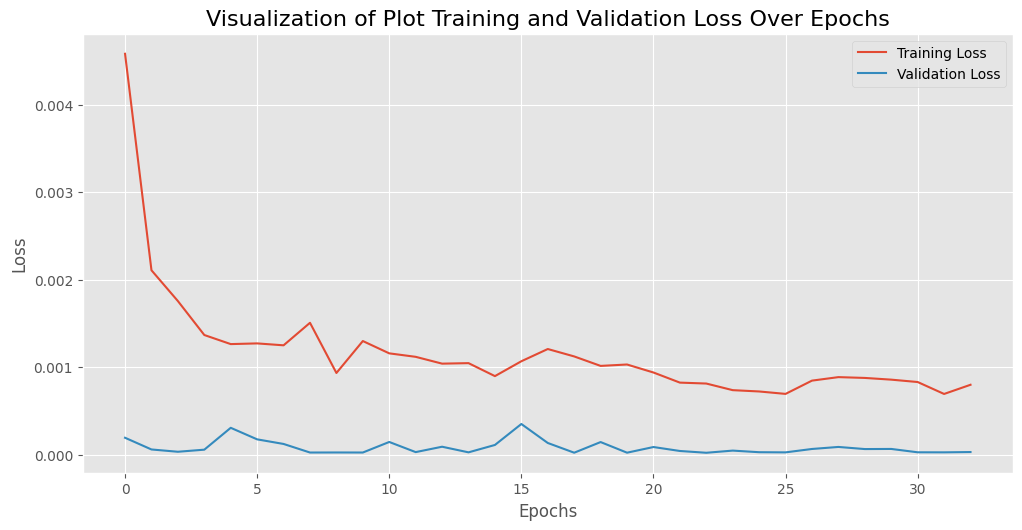

In [107]:
plt.figure(figsize=(12, 5.7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Visualization of Plot Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## **Comparison Plot of Actual Prices vs Predicted Prices**

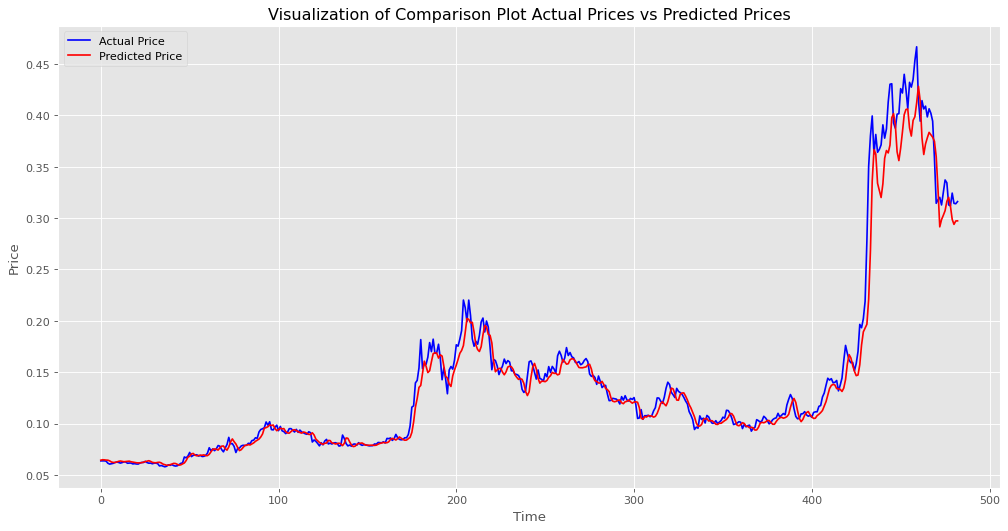

In [108]:
plt.figure(figsize=(15.2, 7.5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_test_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Price', color='red')
plt.title('Visualization of Comparison Plot Actual Prices vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


## **Scatter Plot Predicted vs Actual Price**

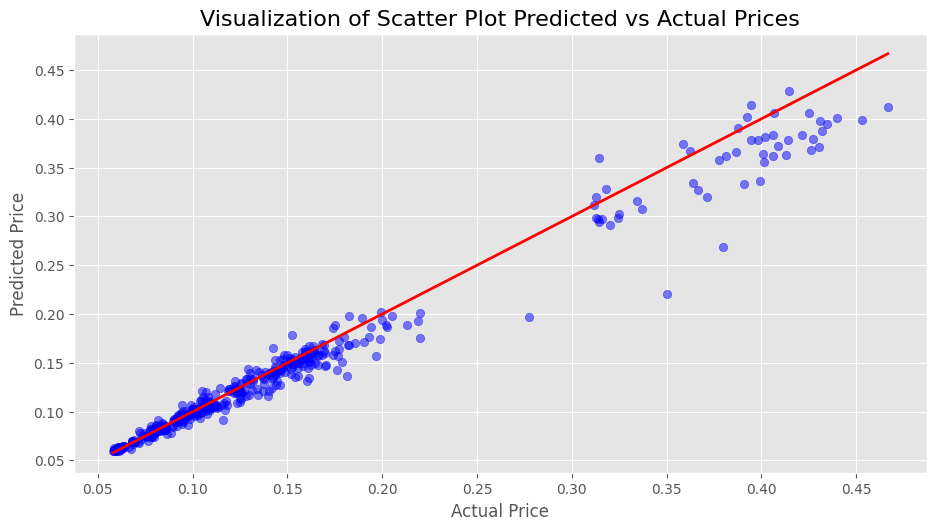

In [109]:
plt.figure(figsize=(11, 5.7))
plt.scatter(y_test_rescaled, y_pred_rescaled, color='blue', alpha=0.5)
plt.plot([y_test_rescaled.min(), y_test_rescaled.max()], [y_test_rescaled.min(), y_test_rescaled.max()], color='red', lw=2)
plt.title('Visualization of Scatter Plot Predicted vs Actual Prices', fontsize=16)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.grid(True)
plt.show()


## **Residual Plot**

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


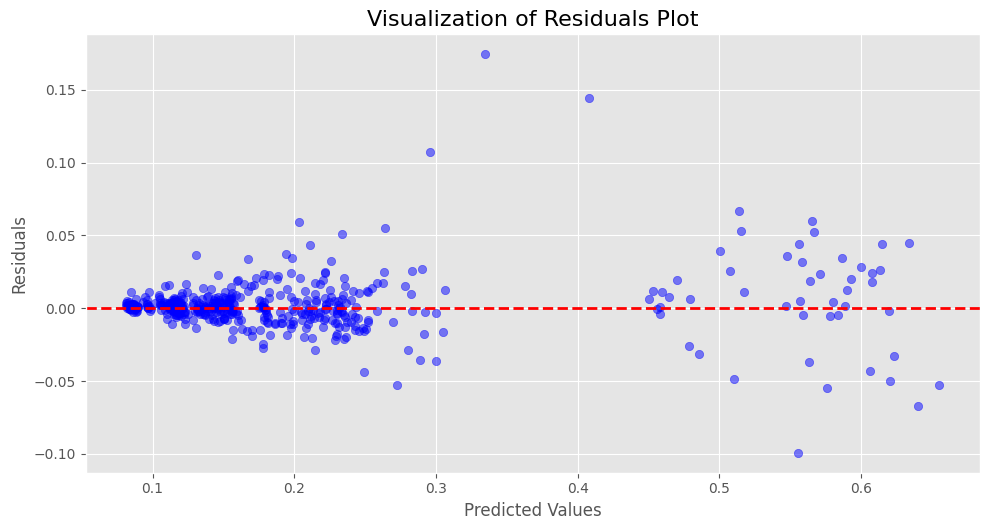

In [110]:
residuals = y_test_seq.flatten() - model.predict(X_test_seq).flatten()

plt.figure(figsize=(10, 5.4))
plt.scatter(model.predict(X_test_seq).flatten(), residuals, alpha=0.5, color='blue')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Visualization of Residuals Plot', fontsize=16)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## **Distribution Residuals Histogram**

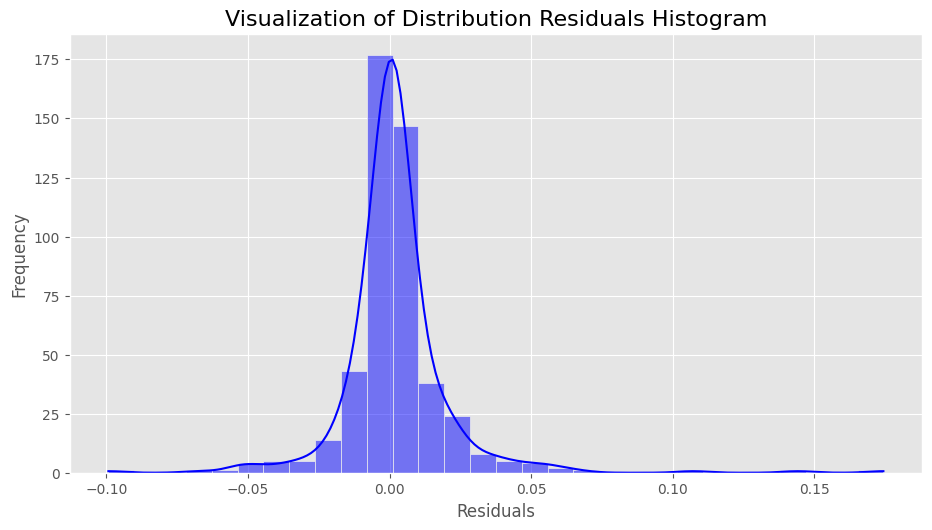

In [111]:
plt.figure(figsize=(11, 5.7))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.title('Visualization of Distribution Residuals Histogram', fontsize=16)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()


## **Evaluation Metrics**

In [112]:
y_pred = model.predict(X_test_seq)

y_test_rescaled = scaler_target.inverse_transform(y_test_seq.reshape(-1, 1))
y_pred_rescaled = scaler_target.inverse_transform(y_pred)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)

rmse = np.sqrt(mse)

mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
mape_percentage = mape * 100

if mape_percentage < 10:
    mape_category = "The Ability of this Forecasting Model is Very Good"
elif 10 <= mape_percentage < 20:
    mape_category = "The Ability of this Forecasting Model is Quite Good"
elif 20 <= mape_percentage < 50:
    mape_category = "The Ability of this Forecasting Model is Quite Decent"
else:
    mape_category = "The Ability of This Forecasting Model is Poor"

print("Model Evaluation Results:")
print(f'MAE: {mae:.5f}')
print(f'MSE: {mse:.5f}')
print(f'RMSE: {rmse:.5f}')
print(f'MAPE: {mape_percentage:.2f}% ({mape_category})')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Model Evaluation Results:
MAE: 0.00711
MSE: 0.00018
RMSE: 0.01330
MAPE: 4.37% (The Ability of this Forecasting Model is Very Good)


# **KNOWLEDGE PRESENTATION**

## **for Analysis**

### **Dogecoin Price**

#### **in Candlestick**

In [113]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                                     open=df['Open'],
                                     high=df['High'],
                                     low=df['Low'],
                                     close=df['Price'])])

fig.update_layout(
    title={'text': 'Visualization of Dogecoin Price with Candlestick (1 Jan 2018 - 31 Dec 2024)', 'x': 0.5, 'xanchor': 'center'},
    xaxis_title='Date',
    yaxis_title='Price',
    width=1000,
    height=610,
)

fig.show()

#### **in Box Plot**

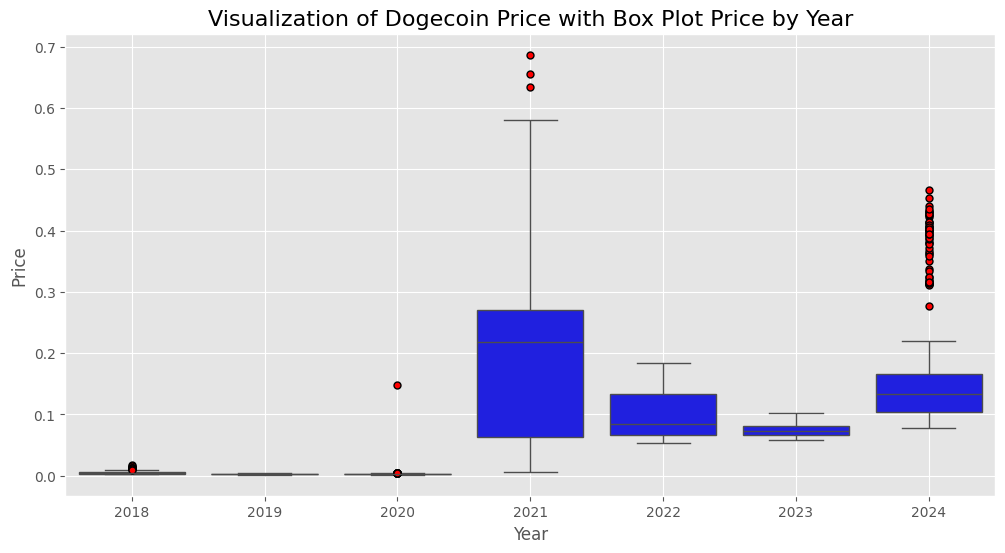

In [114]:
plt.figure(figsize=(12, 6))
flierprops = dict(marker='o', markerfacecolor='red', markersize=5,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x='Year', y='Price', data=df, color='blue', flierprops=flierprops)
plt.title('Visualization of Dogecoin Price with Box Plot Price by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True)
plt.show()


### **Moving Average Price**


#### **Yearly**

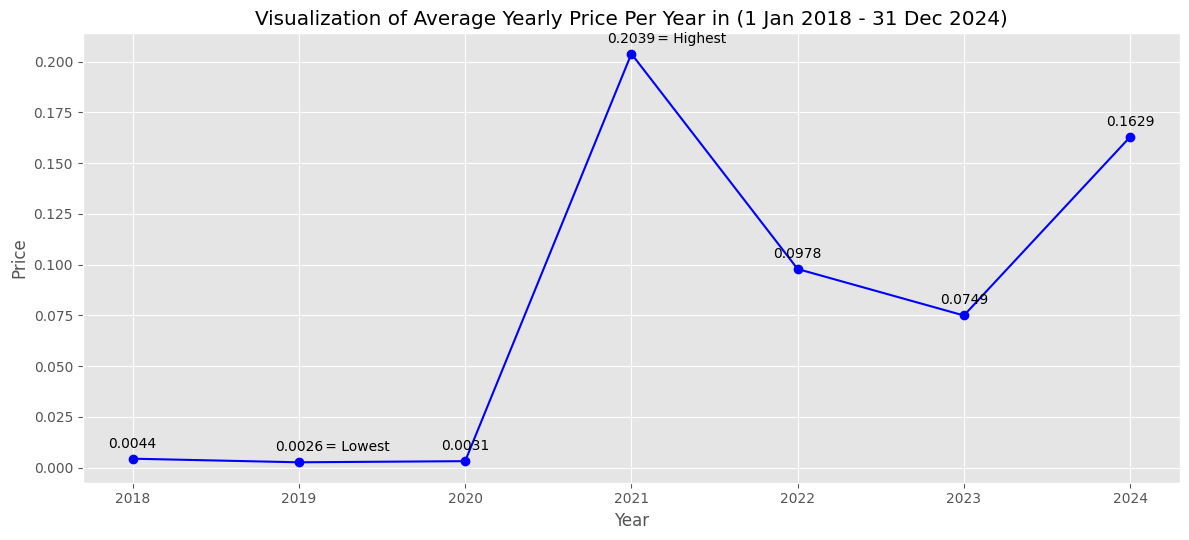

In [115]:
year_mean=df.groupby('Year')['Price'].mean()

plt.figure(figsize=(12, 5.5))
ax = year_mean.plot(marker='o', linestyle='-', color='blue')

for x, y in zip(year_mean.index, year_mean):
    plt.annotate(f'{y:.4f}', xy=(x, y), textcoords='offset points', xytext=(0, 8), ha='center')

max_value = year_mean.max()
min_value = year_mean.min()
max_year = year_mean.idxmax()
min_year = year_mean.idxmin()

ymin, ymax = ax.get_ylim()
plt.text(max_year, max_value+0.025*(ymax-ymin), '      = Highest', ha='left')
plt.text(min_year, min_value+0.025*(ymax-ymin), '      = Lowest', ha='left')

plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Visualization of Average Yearly Price Per Year in (1 Jan 2018 - 31 Dec 2024)')
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Monthly**

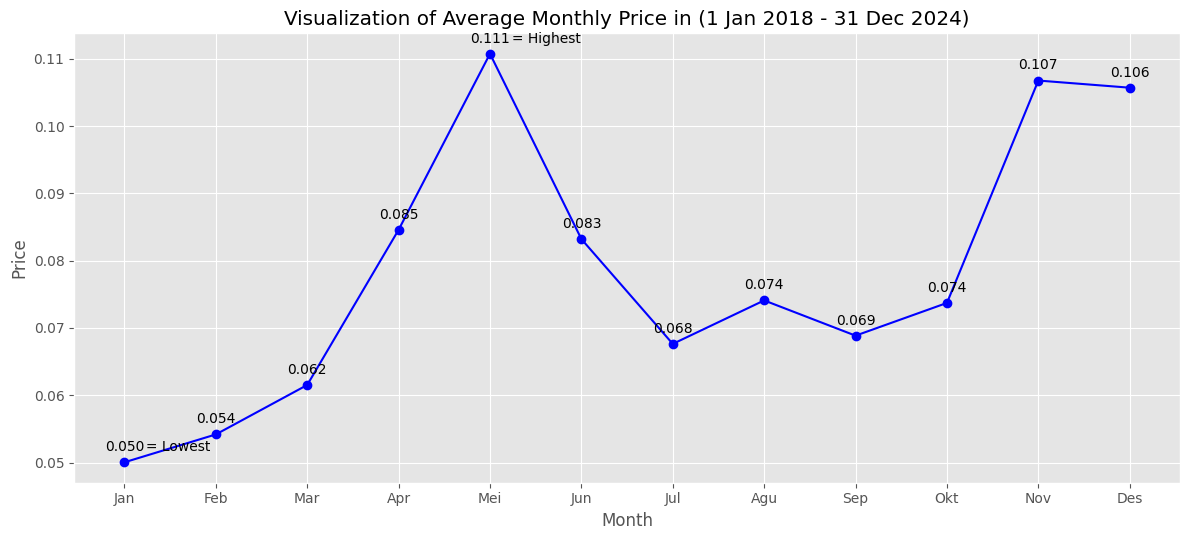

In [116]:
month_mean=df.groupby('Month')['Price'].mean()

plt.figure(figsize=(12, 5.5))
ax = month_mean.plot(marker='o', linestyle='-', color='blue')

for x, y in zip(month_mean.index, month_mean):
    plt.annotate(f'{y:.3f}', xy=(x, y), textcoords='offset points', xytext=(0, 8), ha='center')

max_value = month_mean.max()
min_value = month_mean.min()
max_month = month_mean.idxmax()
min_month = month_mean.idxmin()

ymin, ymax = ax.get_ylim()
plt.text(max_month, max_value+0.025*(ymax-ymin), '     = Highest', ha='left')
plt.text(min_month, min_value+0.025*(ymax-ymin), '     = Lowest', ha='left')

plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Visualization of Average Monthly Price in (1 Jan 2018 - 31 Dec 2024)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'Mei', 'Jun', 'Jul', 'Agu', 'Sep', 'Okt', 'Nov', 'Des'])
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Weekly**

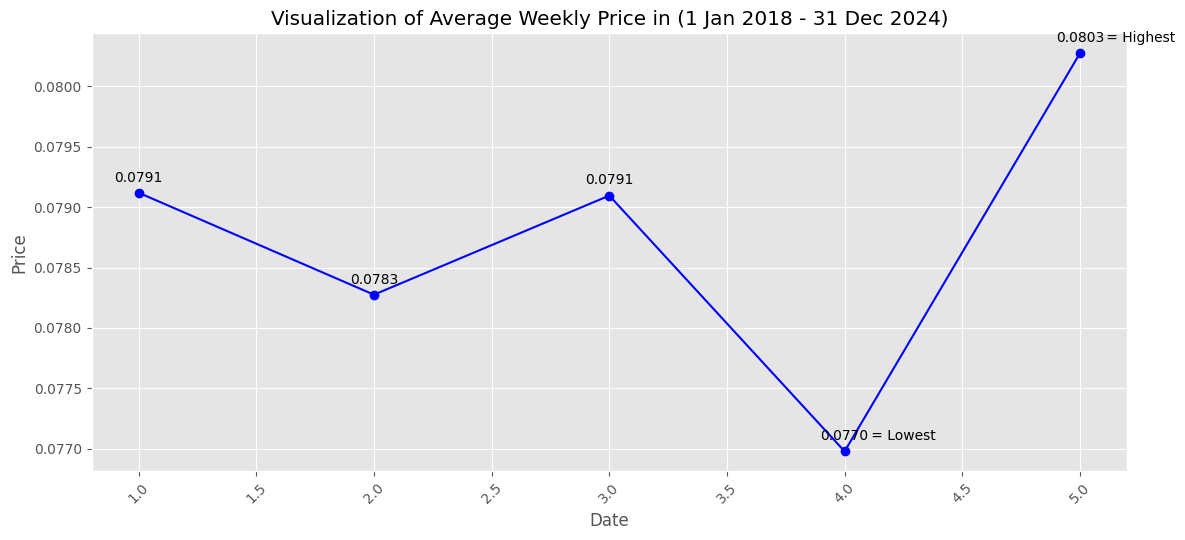

In [117]:
week_mean=df.groupby('Week')['Price'].mean()

plt.figure(figsize=(12, 5.5))
ax = week_mean.plot(marker='o', linestyle='-', color='blue')

for x, y in zip(week_mean.index, week_mean):
    plt.annotate(f'{y:.4f}', xy=(x, y), textcoords='offset points', xytext=(0, 8), ha='center')

max_value = week_mean.max()
min_value = week_mean.min()
max_week = week_mean.idxmax()
min_week = week_mean.idxmin()

ymin, ymax = ax.get_ylim()
plt.text(max_week, max_value+0.025*(ymax-ymin), '      = Highest', ha='left')
plt.text(min_week, min_value+0.025*(ymax-ymin), '      = Lowest', ha='left')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Visualization of Average Weekly Price in (1 Jan 2018 - 31 Dec 2024)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Daily**

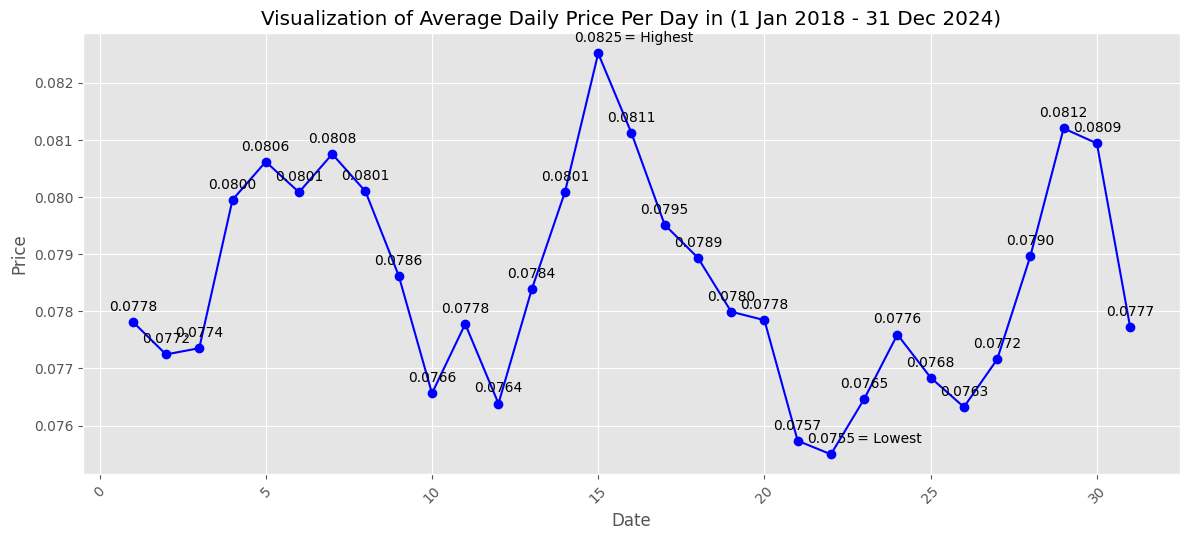

In [118]:
day_mean=df.groupby('Day')['Price'].mean()

plt.figure(figsize=(12, 5.5))
ax = day_mean.plot(marker='o', linestyle='-', color='blue')

for x, y in zip(day_mean.index, day_mean):
    plt.annotate(f'{y:.4f}', xy=(x, y), textcoords='offset points', xytext=(0, 8), ha='center')

max_value = day_mean.max()
min_value = day_mean.min()
max_day = day_mean.idxmax()
min_day = day_mean.idxmin()

ymin, ymax = ax.get_ylim()
plt.text(max_day, max_value+0.025*(ymax-ymin), '      = Highest', ha='left')
plt.text(min_day, min_value+0.025*(ymax-ymin), '      = Lowest', ha='left')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Visualization of Average Daily Price Per Day in (1 Jan 2018 - 31 Dec 2024)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### **Correlation Matrix Table**

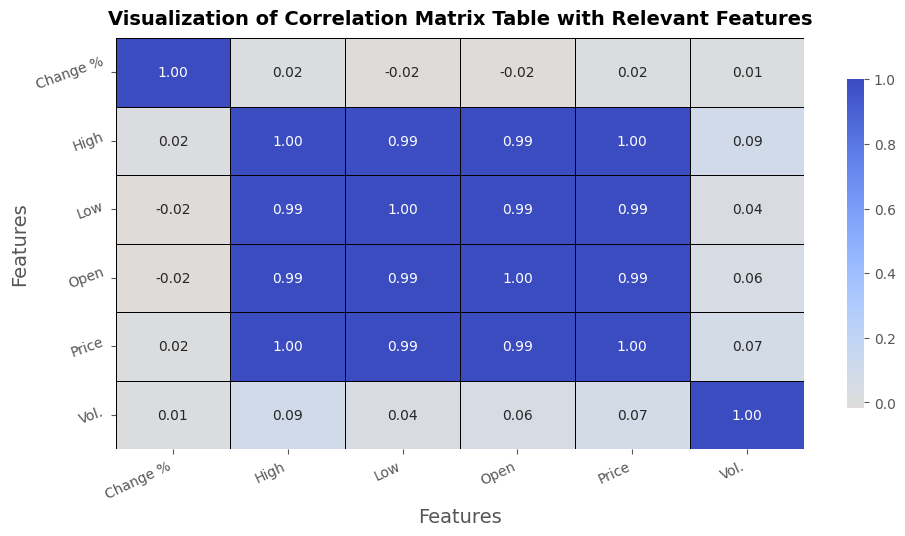

In [119]:
cols_to_exclude = ['Date', 'Day', 'Week', 'Month', 'Year'] + \
                  [f'Price_lag_{lag}' for lag in range(1, 8)]

relevant_cols = df.columns.difference(cols_to_exclude)

correlation_matrix = df[relevant_cols].corr()

plt.figure(figsize=(10.5, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm_r',
    center=0,
    linewidths=0.5,
    linecolor='black',
    fmt='.2f',
    cbar_kws={"shrink": .8}
)

plt.title('Visualization of Correlation Matrix Table with Relevant Features', fontsize=14, weight='bold', pad=10)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(rotation=25, ha='right')
plt.yticks(rotation=20)
plt.tight_layout(pad=3.0)

plt.show()

## **Comparison Table of Actual Prices vs Predicted Prices**

In [120]:
actual_vs_predicted = pd.DataFrame({'Actual Price': y_test_rescaled.flatten(),
                                    'Predicted Price': y_pred_rescaled.flatten()})

actual_vs_predicted

,Actual Price,Predicted Price
0,0.063641,0.062619
1,0.063651,0.062970
2,0.063691,0.062926
3,0.063377,0.062716
4,0.061310,0.062612
...,...,...
478,0.311800,0.329482
479,0.324226,0.316419
480,0.314269,0.310030
481,0.313868,0.314290


### **Comparison Difference**

In [121]:
actual_vs_predicted['Price Difference'] = actual_vs_predicted['Actual Price'] - actual_vs_predicted['Predicted Price']

min_diff = actual_vs_predicted['Price Difference'].min()
max_diff = actual_vs_predicted['Price Difference'].max()

print(f"The smallest difference between Actual Price to Predicted Price is: {min_diff}")
print(f"The largest difference between Actual Price to Predicted Price is: {max_diff}")

The smallest difference between Actual Price to Predicted Price is: -0.06804498153686522
The largest difference between Actual Price to Predicted Price is: 0.11950231479167939


### **Download Predicted Price**

In [122]:
# predicted_price = actual_vs_predicted[['Predicted Price']]

# predicted_price.to_csv('predicted_price.csv', index=False)

# from google.colab import files
# files.download('predicted_price.csv')